In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

## Learning preprocessing

Мы планируем обучать модели на алгоритмах градиентного спуска, который имеет особенно в работе с категориальными признаками. Так, создадим новый датасет для обучения, не обрабатывая числовые данные и кодируя категориальные. Для этого сначала выгрузим ранее кэшированные обработанные датасеты:

In [27]:
train_target = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train_target_for_train.csv')
test = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/test_for_train.csv')
train = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train_for_train.csv')

song_related_feature = ['song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 'name', 'song_year', 'num_played', 'is_featured', 'smaller_song', 'count_artist_played', 'composer_count', 'genre_ids_count', 'is_52', ]
user_related_feature = ['user_activity_msno', 'city', 'bd', 'gender', 'registered_via', 'registration_year', 'expiration_year', 'registration_month',
       'expiration_month', 'registration_day', 'expiration_day', 'duration', 'user_cluster']
neutral_features = ['source_system_tab', 'source_screen_name', 'source_type']

In [28]:
categorical_cols = train.select_dtypes(include=['category']).columns
numerical_cols = train.select_dtypes(include=['int', 'float']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_categorical_encoded = encoder.fit_transform(train[categorical_cols])
train_encoded = np.hstack((train_categorical_encoded, train[numerical_cols]))

## Learning

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

kf = KFold(n_splits=6, shuffle=True, random_state=42)
max_auc = 0
max_accuracy = 0
max_precision = 0
max_recall = 0
max_f1 = 0

validation_errors = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_indices, validate_indices in kf.split(train_encoded):
    dtrain = xgb.DMatrix(train_encoded[train_indices], label=train_target.iloc[train_indices])
    dvalid = xgb.DMatrix(train_encoded[validate_indices], label=train_target.iloc[validate_indices])
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'max_depth': 25,
        'eta': 0.01,
        'subsample': 0.7,
        'lambda' : 2
    }
    num_round = 150
    
    bst = xgb.train(params, dtrain, num_round, evals=[(dvalid, 'validation')], early_stopping_rounds=10, verbose_eval=10)
    validation_errors.append(bst.eval(dvalid))
    
    predictions = bst.predict(dvalid)
    
    auc = roc_auc_score(train_target.iloc[validate_indices], predictions)
    accuracy = accuracy_score(train_target.iloc[validate_indices], predictions.round())
    precision = precision_score(train_target.iloc[validate_indices], predictions.round())
    recall = recall_score(train_target.iloc[validate_indices], predictions.round())
    f1 = f1_score(train_target.iloc[validate_indices], predictions.round())
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    max_auc = max(max_auc, auc)
    max_accuracy = max(max_accuracy, accuracy)
    max_precision = max(max_precision, precision)
    max_recall = max(max_recall, recall)
    max_f1 = max(max_f1, f1)
    
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.plot(validation_errors, marker='o')
plt.title('Validation Error across Cross-Validation Folds')
plt.xlabel('Fold')
plt.ylabel('Validation Error')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(accuracy_scores, marker='o', color='g')
plt.title('Accuracy across Cross-Validation Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(f1_scores, marker='o', color='b')
plt.title('F1 Score across Cross-Validation Folds')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.grid(True)

plt.tight_layout()
plt.show()


[0]	validation-error:0.46051
[10]	validation-error:0.33068
[20]	validation-error:0.32333
[30]	validation-error:0.32071
[40]	validation-error:0.31876
[50]	validation-error:0.31729
[60]	validation-error:0.31593
[70]	validation-error:0.31458
[80]	validation-error:0.31330
[90]	validation-error:0.31201
[100]	validation-error:0.31096
[110]	validation-error:0.30965
[120]	validation-error:0.30866
[130]	validation-error:0.30783
[140]	validation-error:0.30711
[149]	validation-error:0.30664
[0]	validation-error:0.46914
[10]	validation-error:0.33143
[20]	validation-error:0.32342
[30]	validation-error:0.32020
[40]	validation-error:0.31766
[50]	validation-error:0.31627
[60]	validation-error:0.31439
[70]	validation-error:0.31319
[80]	validation-error:0.31199
[90]	validation-error:0.31084
[100]	validation-error:0.30966
[110]	validation-error:0.30886
[120]	validation-error:0.30778


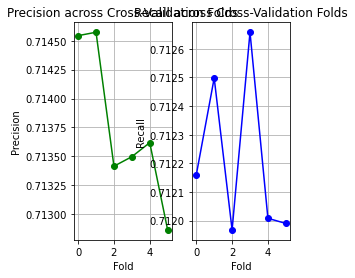

In [ ]:
plt.subplot(1, 3, 2)
plt.plot(precision_scores, marker='o', color='g')
plt.title('Precision across Cross-Validation Folds')
plt.xlabel('Fold')
plt.ylabel('Precision')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(recall_scores, marker='o', color='b')
plt.title('Recall across Cross-Validation Folds')
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.grid(True)

In [ ]:
print(f"Максимальный AUC по результатам кросс-валидации равен {max_auc}")

Максимальный AUC по результатам кросс-валидации равен 0.7851295288654351


## Testing

Проведём аналогичные преобразования на том же энкодере с тестовой выборкой, а затем протестируем модель.

In [ ]:
test_categorical = test.select_dtypes(include=['category'])
test_categorical_encoded = encoder.transform(test[categorical_cols])
test_encoded = np.hstack((test_categorical_encoded, test[numerical_cols]))

Сохраним результаты в файл "submission.csv"

In [ ]:
dtest = xgb.DMatrix(test_encoded)
predictions = bst.predict(dtest)

predictions_df = pd.DataFrame(predictions, columns=['target'])
predictions_df['id'] = range(len(test))
predictions_df = predictions_df[['id', 'target']]
predictions_df.to_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/submission.csv', index=False)